# **Homework 6: Instance Segmentation**

Objectives:


*   Review object detection with YOLOv3 from Homework 3
*   Review semantic segmentation from Homework 5
*   Combine object detection and semantic segmentation to implement instance segmentation method

Total points: 100

If any question, please contact the TAs via TA hours, or email.



## Introduction

In this homework, you'll use object detection and semantic segmentation techniques to perform instance segmentation on [the provided image](https://drive.google.com/file/d/1hnBJlCzjxtOtPFM6sGAynJIlAnGKmhqj/view?usp=sharing). The detailed steps are as follows:

1. Detect three flasks in the image using YOLOv3
2. For each flask, run the semantic segmentation inside the detection box
3. Combine three results in one image, where each flask is indicated by a mask of unique color

Hint:
1. You can create a new image containing only one flask for each of them then perform the semantic segmentation. In this way, please be careful with when you do the scaling
2. Or, for each detection box, you can cover all the pixels outside the box with mask of 0s to keep the original size

**NOTE:**
Please do the semantic segmentation seperately for the three flasks. Changing color of the whole segmentation result is not acceptable.

Feel free to reuse the code from previous homeworks

**Metric:**

10 points for implementing object detection\
10 points for the correct bounding boxes\
20 points for seperating three flasks\
10 points for performing semantic segmentation on three new images\
20 points for combining three segmentation masks in one final mask\
30 points for visualization in both parts

# Download and install

In [71]:
try:
  !rm -rf HW3_object_track
except:
  pass

# Get the flasks image
!gdown 1hnBJlCzjxtOtPFM6sGAynJIlAnGKmhqj

# Download data
!gdown 1g10Er1vhNbrqa0pZf0R08B9RrmRxIoWt

# Install filterpy
! unzip LabPicsV1.zip

from IPython.display import clear_output
clear_output()

# Get some essential codes
!git clone https://github.com/JamesLiang819/HW3_object_track.git

# Download pre-trained weights for yolov3
!wget https://pjreddie.com/media/files/yolov3.weights

# Install filterpy
! pip install filterpy

fatal: destination path 'HW3_object_track' already exists and is not an empty directory.
'wget' is not recognized as an internal or external command,
operable program or batch file.


You should consider upgrading via the 'C:\Users\Ryan Barry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [72]:
from __future__ import print_function

# Basic models and utils
from HW3_object_track.models import *
from HW3_object_track.utils import *

# System
import os, sys, time, datetime, random
import argparse
from numba import jit
from tqdm import tqdm


# Data processing
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment
from filterpy.kalman import KalmanFilter

# Pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as tf
import torchvision.models.segmentation
from torch.autograd import Variable

# Image processing
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from skimage import io

# Object Detection

Please refer to homework 3, be careful with the transformed bounding box.

This should be the result of this step:

https://drive.google.com/file/d/12v-E4JPSD9YSbJ3VU2siYq287HqnpOcN/view?usp=sharing


In [206]:
config_path='HW3_object_track/config/yolov3.cfg'
weights_path='yolov3.weights'
class_path='HW3_object_track/config/coco.names'
img_size=416
conf_thres=0.3
nms_thres=0.1

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

In [207]:
# Download pre-trained weights for yolov3
import urllib.request

url = "https://pjreddie.com/media/files/yolov3.weights"
filename = "yolov3.weights"

urllib.request.urlretrieve(url, filename)

('yolov3.weights', <http.client.HTTPMessage at 0x1dbd6d2c6a0>)

In [281]:
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda() 
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW6\.venv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [282]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float().to(device)
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [283]:
# you may try your own image by changing the img_path
img_path = "Flasks.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

Inference Time: 0:00:00.258823


<Figure size 640x480 with 0 Axes>

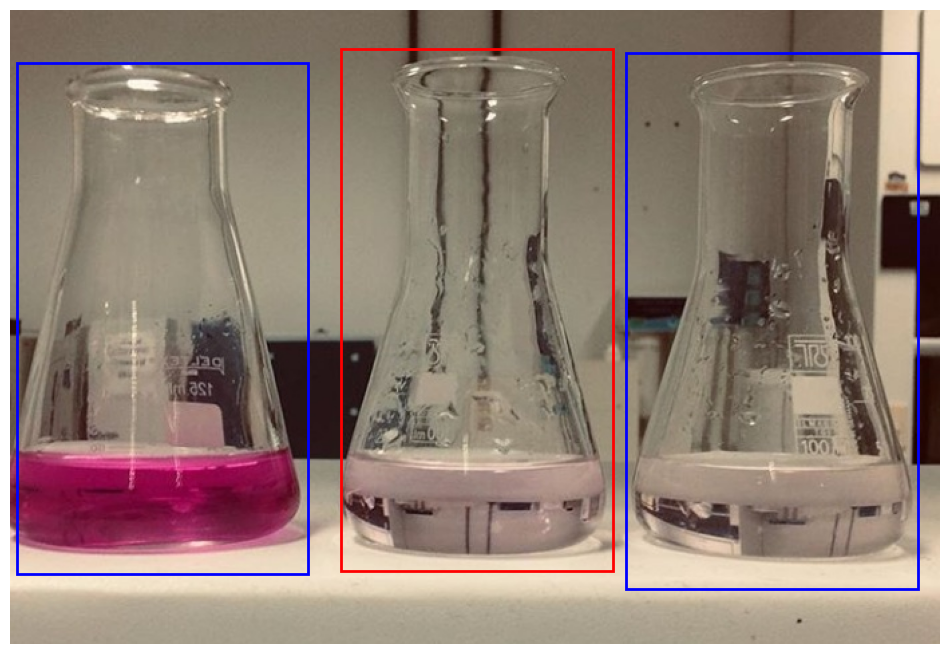

In [284]:
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1.cpu(), y1.cpu()), box_w.cpu(), box_h.cpu(), linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

# Instance Segmentation

For this part, please refer to homework 5
This should be the result of this step:

https://drive.google.com/file/d/1EmPjgvoNIJpCmuPRRJjeG_CU4dHuaWpF/view?usp=sharing

In [285]:
modelPath = "C:/Users/Ryan Barry/OneDrive - rit.edu/Laptop Backup/Desktop/RIT/Robot Perception/Homework/HW5/Final.torch"  # Path to trained model

<Figure size 640x480 with 0 Axes>

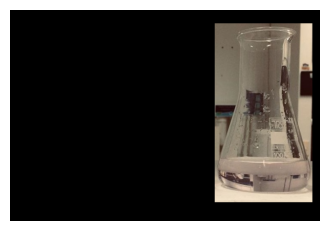

<Figure size 640x480 with 0 Axes>

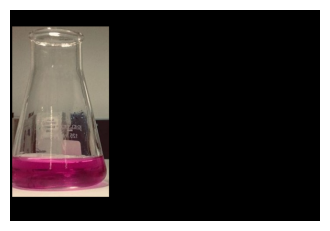

<Figure size 640x480 with 0 Axes>

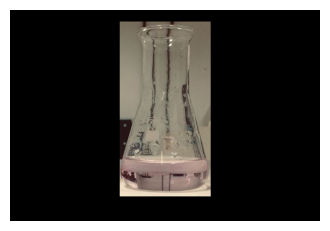

In [286]:
img = np.array(img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    num_detections = detections.shape[0]
    height, width, channels = img.shape
    Image_masked = np.zeros((num_detections, height, width, channels), dtype='uint8')
    # browse detections and draw bounding boxes
    for i, [x1, y1, x2, y2, conf, cls_conf, cls_pred] in enumerate(detections):
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        y2 = ((y2 - pad_y // 2) / unpad_h) * img.shape[0]
        x2 = ((x2 - pad_x // 2) / unpad_w) * img.shape[1]
        y1 = int(y1.item())
        y2 = int(y2.item())
        x1 = int(x1.item())
        x2 = int(x2.item())
        Image_masked[i, y1:y2, x1:x2, :] = img[y1:y2, x1:x2, :]
        
for i in range(num_detections):
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(4,3))
    ax.imshow(Image_masked[i])
    ax.axis('off')  # Add this line to remove the axis
    plt.show()

In [287]:
width=height=900 # image width and height
batchSize=2

TrainFolder="C:/Users/Ryan Barry/OneDrive - rit.edu/Laptop Backup/Desktop/RIT/Robot Perception/Homework/HW5/content/LabPicsV1/Simple/Train/"
ListImages=os.listdir(os.path.join(TrainFolder, "Image")) # Create list of images

transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])

In [288]:
def ReadRandomImage(): # First lets load random image and  the corresponding annotation
    idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, "Image", ListImages[idx]))[:,:,0:3]
    Filled =  cv2.imread(os.path.join(TrainFolder, "Semantic/16_Filled", ListImages[idx].replace("jpg","png")),0)
    Vessel =  cv2.imread(os.path.join(TrainFolder, "Semantic/1_Vessel", ListImages[idx].replace("jpg","png")),0) #(1pt)TODO: Read Vessel mask map
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Vessel is not None:  AnnMap[ Vessel == 1 ] = 1
    if Filled is not None:  AnnMap[ Filled  == 1 ] = 2 #(1pt)TODO: Set pixel of annotation map with Filled to 2
    Img=transformImg(Img) #(1pt)TODO: Apply transformation to image
    AnnMap=transformAnn(AnnMap)
    return Img,AnnMap

In [289]:
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width]) #Initiate the annotation map with proper size.
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    return images, ann

In [290]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # Set device to cuda
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net=Net.to(device)
Learning_Rate=1e-5
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW6\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW6\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


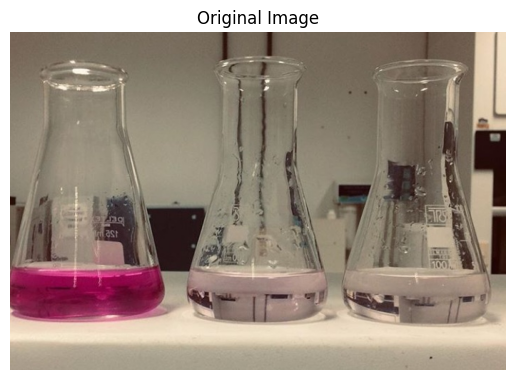

c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW6\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW6\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW6\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default va

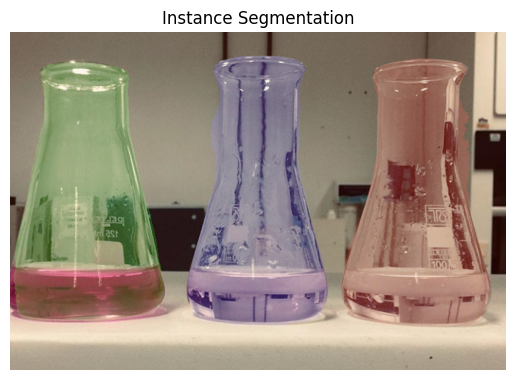

In [299]:
original_image = Image.open(img_path)
plt.imshow(original_image)
plt.axis('off')
plt.title('Original Image')
plt.show()
original_image = np.array(original_image)
# Define translucency level for the tint (0.0 - fully transparent, 1.0 - fully opaque)
translucency = 0.25

# Specify the color channels to maximize for each instance
channels_to_maximize = [0, 1, 2]  # Red for the first instance, green for the second, blue for the third, etc.


# Iterate through each mask
for i, img in enumerate(Image_masked):
    height_orgin, width_orgin, _ = img.shape  # Get image original size
    Img = transformImg(img)  # Transform to PyTorch tensor
    Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load the network
    Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Change final layer to 3 classes
    Net.load_state_dict(torch.load(modelPath))
    Net = Net.to(device)
    Net.eval()
    with torch.no_grad():
        Prd = Net(Img)['out']  # Run the network
    Prd = torchvision.transforms.Resize((height_orgin, width_orgin))(Prd)[0]  # Resize to original size
    seg = torch.argmax(Prd, dim=0).cpu().detach().numpy()

    # Create a color mask and overlay it onto the original image
    mask = seg > 0
    color_mask = img.copy()
    color_mask[..., channels_to_maximize[i % len(channels_to_maximize)]] = 255  # Maximize the specified color channel
    original_image[mask] = (1 - translucency) * img[mask] + translucency * color_mask[mask]

# Display the overlaid image
plt.imshow(original_image)
plt.axis('off')
plt.title('Instance Segmentation')
plt.savefig(img_path.replace(".jpg", "-instance_segmentation.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()
